In [1]:
import torch
import collections

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from models import ShallowNN
from evals import evaluate, pairwise_euclidean_distance
from evals import pairwise_euclidean_distance, layerwise_proximity, layerwise_eccentricity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

ModuleNotFoundError: No module named 'models'

In [2]:
client_ids = [f"{i}_{j}" for i in range(4) for j in range(6)]

In [3]:
dummy = torch.load("checkpt/saving/epoch_500/global_1/global_model.pth")
critarians = [item for item in dummy]

### Calculating eccentricities in each iteration with $\xi^P$


In [6]:
df_dict = {}
for iter in range(1,21):
    
    state_dicts = {
        key: torch.load("checkpt/saving/epoch_500/global_" + str(iter) + "/clients/client_model_" + str(key) + ".pth")
        for key in client_ids
    }
    
    layer_prox = {}
    for cri in critarians:
        layer_prox[cri] = layerwise_eccentricity(state_dicts,cri,pairwise_euclidean_distance)
    
    round_frame = pd.DataFrame.from_dict(layer_prox, orient='index')
    round_frame = round_frame.T.reset_index().rename(columns={"index":"client_id"})
    
    averages = [] 
    for index, client in round_frame.iterrows():
        avg = (client['layer_1.weight'] + client['layer_1.bias'] + client['layer_2.weight'] + client['layer_2.bias'] + client['layer_3.weight'] + client['layer_3.bias'])/6
        averages.append(round(avg,4))
    round_frame["average_weight"] = averages
    
    df_dict[iter] = round_frame

### Taking eccentricities of each client into a dict

In [10]:
ecc_dict = {}
for client in client_ids:   
    client_ecc = []
    for iter in range(1,21):
        client_ecc.append(df_dict[iter][df_dict[iter]['client_id'] == client].average_weight.values.item())
        ecc_dict[client] = client_ecc

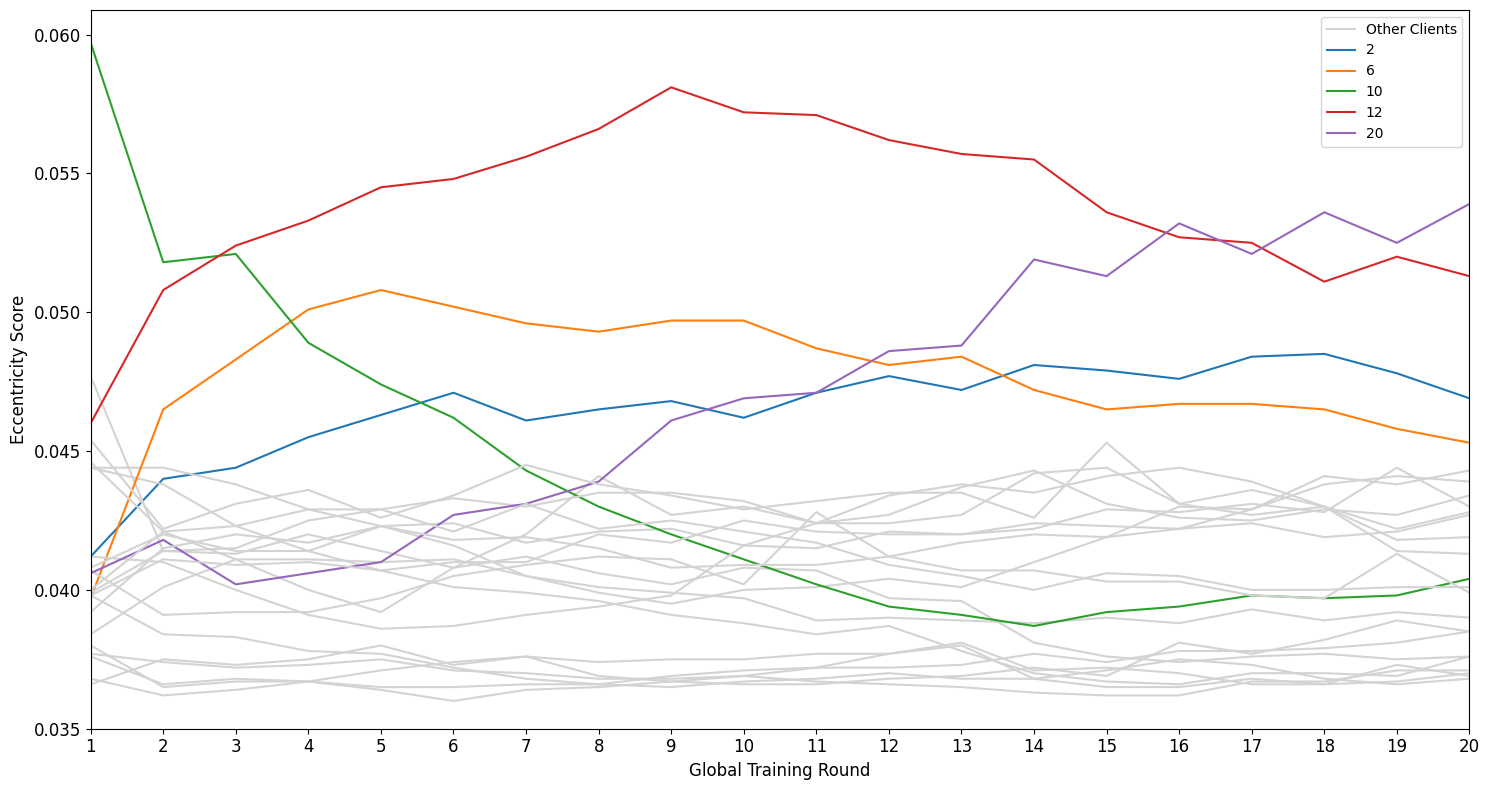

In [14]:
x_values = list(range(1, 21))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(ecc_dict.items()):
    if i+1 in (10,12, 2,6,20):
        plt.plot(x_values, values, label=str(i + 1))  # Set legend label from 1 to 24
    else:
        plt.plot(x_values, values, label='Other Clients',  color='lightgray')

def legend_without_duplicate_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique))

plt.xlim(1,len(values))
plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eccentricity Score', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
legend_without_duplicate_labels(plt)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()